I tried training an agent for 100 vehicles instead of 10, but it didn't really learn.
Some of the cell outputs might say 100 vehicles instead of 10, but the paper only uses 10 vehicles.

In [1]:
# https://github.com/ray-project/ray/blob/master/rllib/examples/sb2rllib_rllib_example.py
import ray
from ray import tune, air
import ray.rllib.algorithms.ppo as ppo
from IPython.display import display, clear_output
from time import sleep
from glob import glob
from pathlib import Path
from tqdm import tqdm
from itertools import count
import matplotlib.pyplot as plt

In [2]:
if ray.is_initialized():
    ray.shutdown()
ray.init(num_gpus=1, local_mode=False)

Usage stats collection is enabled by default for nightly wheels. To disable this, run the following command: `ray disable-usage-stats` before starting Ray. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.


2023-02-27 01:48:17,262	INFO worker.py:1536 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 


Python version:,3.8.15
Ray version:,3.0.0.dev0
Dashboard:,http://127.0.0.1:8266


In [3]:
# env config
import gymnasium as gym
import platoonenv

env_name = "Platoon-v6"
env_config=dict(
    num_vehicles=10,
    steps_before_truncation=200,
    cycle_interval=2,
    attack_interval=1,
    cycle_num=1,
)
env = gym.make(
    id=env_name,
    render_mode="canvas",
    env_config=env_config,
)

print(env_name,"\n------------------")
print("reward_threshold", env.spec.reward_threshold)
print("max_episode_steps", env.spec.max_episode_steps)

Platoon-v6 
------------------
reward_threshold None
max_episode_steps None


In [4]:
from ray.rllib.utils import check_env

check_env(env)

2023-02-27 01:48:21,115	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.


In [5]:
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.dqn import DQNConfig
from ray.rllib.algorithms.random_agent import RandomAgentConfig

ppo_config = (
    PPOConfig()
    .environment(env=env_name, env_config=env_config)
    .framework("torch")
    .rollouts(num_rollout_workers=3)
    .resources(num_gpus=1, num_cpus_for_local_worker=0.5)
)

ppo_config.horizon = env.spec.max_episode_steps
ppo_config.create_env_on_local_worker=True

dqn_config = (
    DQNConfig()
    .environment(env=env_name, env_config=env_config)
    .framework("torch")
    .rollouts(num_rollout_workers=3)
    .resources(num_gpus=0.5, num_cpus_for_local_worker=0.5)
)
dqn_config.horizon = env.spec.max_episode_steps
dqn_config.create_env_on_local_worker=True

random_config = (
    RandomAgentConfig()
    .environment(env=env_name, env_config=env_config)
    .framework("torch")
    .rollouts(num_rollout_workers=3)
    .resources(num_gpus=0.5, num_cpus_for_local_worker=0.5)
)
random_config.horizon = env.spec.max_episode_steps
random_config.create_env_on_local_worker=True

In [6]:
ppo_algo = ppo_config.build()

(RolloutWorker pid=24228) 2023-02-27 01:48:30,962	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
(RolloutWorker pid=1260) 2023-02-27 01:48:31,008	INFO policy.py:1196 -- Policy (worker=2) running on CPU.
(RolloutWorker pid=1260) 2023-02-27 01:48:31,008	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=24228) 2023-02-27 01:48:31,037	INFO policy.py:1196 -- Policy (worker=1) running on CPU.
(RolloutWorker pid=24228) 2023-02-27 01:48:31,037	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=19308) 2023-02-27 01:48:31,035	INFO policy.py:1196 -- Policy (worker=3) running on CPU.
(RolloutWorker pid=19308) 2023-02-27 01:48:31,035	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
2023-02-27 01:48:31,152	INFO policy.py:1196 -- Policy (work

In [7]:
!ray status

Traceback (most recent call last):
  File "C:\Users\TeamD\.conda\envs\rllib\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\TeamD\.conda\envs\rllib\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\TeamD\.conda\envs\rllib\Scripts\ray.exe\__main__.py", line 7, in <module>
  File "C:\Users\TeamD\.conda\envs\rllib\lib\site-packages\ray\scripts\scripts.py", line 2433, in main
    return cli()
  File "C:\Users\TeamD\.conda\envs\rllib\lib\site-packages\click\core.py", line 1130, in __call__
    return self.main(*args, **kwargs)
  File "C:\Users\TeamD\.conda\envs\rllib\lib\site-packages\click\core.py", line 1055, in main
    rv = self.invoke(ctx)
  File "C:\Users\TeamD\.conda\envs\rllib\lib\site-packages\click\core.py", line 1657, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "C:\Users\TeamD\.conda\envs\rllib\lib\site-packages\click\core.py", line 1404, in invoke
    

In [8]:
dqn_algo = dqn_config.build()

(RolloutWorker pid=21844) 2023-02-27 01:48:46,386	INFO policy.py:1196 -- Policy (worker=3) running on CPU.
(RolloutWorker pid=21844) 2023-02-27 01:48:46,386	INFO torch_policy.py:184 -- Found 1 visible cuda devices.
(RolloutWorker pid=18660) 2023-02-27 01:48:46,381	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
(RolloutWorker pid=18660) 2023-02-27 01:48:46,494	INFO policy.py:1196 -- Policy (worker=1) running on CPU.
(RolloutWorker pid=18660) 2023-02-27 01:48:46,494	INFO torch_policy.py:184 -- Found 1 visible cuda devices.
(RolloutWorker pid=29008) 2023-02-27 01:48:46,492	INFO policy.py:1196 -- Policy (worker=2) running on CPU.
(RolloutWorker pid=29008) 2023-02-27 01:48:46,492	INFO torch_policy.py:184 -- Found 1 visible cuda devices.
2023-02-27 01:48:46,536	INFO policy.py:1196 -- Policy (worker=loca

In [9]:
!ray status

Traceback (most recent call last):
  File "C:\Users\TeamD\.conda\envs\rllib\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\TeamD\.conda\envs\rllib\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\TeamD\.conda\envs\rllib\Scripts\ray.exe\__main__.py", line 7, in <module>
  File "C:\Users\TeamD\.conda\envs\rllib\lib\site-packages\ray\scripts\scripts.py", line 2433, in main
    return cli()
  File "C:\Users\TeamD\.conda\envs\rllib\lib\site-packages\click\core.py", line 1130, in __call__
    return self.main(*args, **kwargs)
  File "C:\Users\TeamD\.conda\envs\rllib\lib\site-packages\click\core.py", line 1055, in main
    rv = self.invoke(ctx)
  File "C:\Users\TeamD\.conda\envs\rllib\lib\site-packages\click\core.py", line 1657, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "C:\Users\TeamD\.conda\envs\rllib\lib\site-packages\click\core.py", line 1404, in invoke
    

In [10]:
random_algo = random_config.build()

In [11]:
!ray status

Traceback (most recent call last):
  File "C:\Users\TeamD\.conda\envs\rllib\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\TeamD\.conda\envs\rllib\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\TeamD\.conda\envs\rllib\Scripts\ray.exe\__main__.py", line 7, in <module>
  File "C:\Users\TeamD\.conda\envs\rllib\lib\site-packages\ray\scripts\scripts.py", line 2433, in main
    return cli()
  File "C:\Users\TeamD\.conda\envs\rllib\lib\site-packages\click\core.py", line 1130, in __call__
    return self.main(*args, **kwargs)
  File "C:\Users\TeamD\.conda\envs\rllib\lib\site-packages\click\core.py", line 1055, in main
    rv = self.invoke(ctx)
  File "C:\Users\TeamD\.conda\envs\rllib\lib\site-packages\click\core.py", line 1657, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "C:\Users\TeamD\.conda\envs\rllib\lib\site-packages\click\core.py", line 1404, in invoke
    

In [12]:
checkpoints = sorted(glob(str(Path("saved_models","**","checkpoint_*"))))

In [13]:
import ipywidgets as widgets

In [14]:
def dirs_only(paths):
    return [path for path in paths if Path(path).is_dir()]

In [15]:
suffix = "many"
ppo_save_dir = Path("saved_models",f"{env_name}-{str(ppo_algo)}-{env_config['num_vehicles']}vehicles-{suffix}")
ppo_save_dir.mkdir(parents=True, exist_ok=True)
print(ppo_save_dir)

ppo_checkpoint_path = sorted(dirs_only(glob(str(ppo_save_dir / "*"))))[-1] # grab latest

w = widgets.Dropdown(
    layout={'width': 'initial'},
    options=checkpoints,
    value=ppo_checkpoint_path,
    description='PPO:'
)

def on_change(change):
    global ppo_checkpoint_path
    if change['type'] == 'change' and change['name'] == 'value':
        print("changed to %s" % change['new'])
        ppo_checkpoint_path = change['new']

w.observe(on_change)
display(w)

saved_models\Platoon-v6-PPO-100vehicles-many


Dropdown(description='PPO:', index=133, layout=Layout(width='initial'), options=('saved_models\\Platoon-v0-cur…

In [16]:
suffix="many"
dqn_save_dir = Path("saved_models",f"{env_name}-{str(dqn_algo)}-{env_config['num_vehicles']}vehicles-{suffix}")
dqn_save_dir.mkdir(parents=True, exist_ok=True)
print(dqn_save_dir)

dqn_checkpoint_path = sorted(dirs_only(glob(str(dqn_save_dir / "*"))))[-1] # grab latest

w = widgets.Dropdown(
    layout={'width': 'initial'},
    options=checkpoints,
    value=dqn_checkpoint_path,
    description='DQN:'
)

def on_change(change):
    global dqn_checkpoint_path
    if change['type'] == 'change' and change['name'] == 'value':
        print("changed to %s" % change['new'])
        dqn_checkpoint_path = change['new']

w.observe(on_change)
display(w)

saved_models\Platoon-v6-DQN-100vehicles-many


Dropdown(description='DQN:', index=59, layout=Layout(width='initial'), options=('saved_models\\Platoon-v0-curi…

In [17]:
print(f"PPO restoring from checkpoint: {ppo_checkpoint_path}")
ppo_algo.restore(ppo_checkpoint_path)

2023-02-27 01:48:54,122	INFO trainable.py:790 -- Restored on 127.0.0.1 from checkpoint: saved_models\Platoon-v6-PPO-100vehicles-many\checkpoint_000280
2023-02-27 01:48:54,123	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 280, '_timesteps_total': None, '_time_total': 3600.3139855861664, '_episodes_total': 32372}


PPO restoring from checkpoint: saved_models\Platoon-v6-PPO-100vehicles-many\checkpoint_000280


In [18]:
print(f"DQN restoring from checkpoint: {dqn_checkpoint_path}")
dqn_algo.restore(dqn_checkpoint_path)

2023-02-27 01:48:54,569	INFO trainable.py:790 -- Restored on 127.0.0.1 from checkpoint: saved_models\Platoon-v6-DQN-100vehicles-many\checkpoint_000454
2023-02-27 01:48:54,569	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 454, '_timesteps_total': None, '_time_total': 3606.345464706421, '_episodes_total': 4208}


DQN restoring from checkpoint: saved_models\Platoon-v6-DQN-100vehicles-many\checkpoint_000454


In [19]:
{
    "ppo":{k:v for k,v in ppo_algo.get_state().items() if k != "last_result"},
    "dqn": {k:v for k,v in dqn_algo.get_state().items() if k != "last_result"},
}

{'ppo': {'experiment_id': '151c8b7d77f2454b84cc3ef32bd7cc20',
  'iteration': 280,
  'timesteps_total': None,
  'time_total': 3600.3139855861664,
  'episodes_total': 32372,
  'ray_version': '3.0.0.dev0'},
 'dqn': {'experiment_id': 'b66c0781078549439fbcf6ceec97ceb5',
  'iteration': 454,
  'timesteps_total': None,
  'time_total': 3606.345464706421,
  'episodes_total': 4208,
  'ray_version': '3.0.0.dev0'}}

In [20]:
# iter = dqn_algo.get_state()["iteration"]
# assert dqn_algo.get_state()["iteration"] == ppo_algo.get_state()["iteration"]

In [21]:
import numpy as np

In [22]:
%matplotlib ipympl

In [23]:
env = gym.make(
    id=env_name,
    render_mode="canvas",
    env_config=env_config
)

In [24]:
# suffix = "iter" + dqn_algo.get_state()["iteration"]
suffix = "grow-2"
figure_save_dir = Path("figures", f"{env_name}-{env_config['num_vehicles']}vehicles-{suffix}")
figure_save_dir.mkdir(parents=True, exist_ok=True)
print(f"saving to \"{figure_save_dir}\"")

saving to "figures\Platoon-v6-100vehicles-grow-2"


In [25]:
from IPython.display import display, clear_output
from ipycanvas import Canvas
while True:
    obs, info = env.reset(seed=0)
    for i in count():
        action = ppo_algo.compute_single_action(obs)
        next_obs, reward, done, trunc, info = env.step(action)
        obs = next_obs
        # clear_output()
        # display(env.render())
        if done or trunc:
            break
    if i <= 10:
        break
# display(env.render())
canvas: Canvas = env.render()
display(canvas)

Canvas(height=792, width=8500)

In [26]:
# find the first index of a zero and add 1, or return 0 otherwise
def find_first_zero(x):
    try:
        return np.where(x==0)[0][0] + 1
    except IndexError:
        return 0

In [27]:
policies = {
    "PPO": lambda obs, info: ppo_algo.compute_single_action(obs, explore=True),
    "DQN": lambda obs, info: dqn_algo.compute_single_action(obs, explore=True),
    "random": lambda obs, info: env.action_space.sample(),
    "grow": lambda obs, info: find_first_zero(info["members"]),
    "no-op": lambda obs, info: 0,
}

In [28]:
history = {}

In [29]:
num_episodes = 100
with tqdm(total=env_config["steps_before_truncation"]*len(policies)*num_episodes) as pbar:
    for policy_name, policy in policies.items():
        pbar.set_description(policy_name)
        episodes = []
        for episode in range(num_episodes):
            actions = []
            rewards = []
            observations = []
            infos = []
            obs, info = env.reset(seed=episode+10222556)
            observations.append(obs)
            infos.append(info)
            blunders = []
            for episode_step in count():
                action = policy(obs, info)
                blunder_predict = action > 0 and info["modes"][action-1]==0 and info["members"][action-1]==0 and (info["probs"]*info["severities"])[action-1].sum() >= 5
                next_obs, reward, terminated, truncated, info = env.step(action)
                if blunder_predict:
                    blunders.append({
                        "episode_step": episode_step,
                        "blunder_predict": blunder_predict, 
                        "terminated": terminated,
                        "truncated": truncated,
                        "saved": action-1 in info["cycled"]
                    })
                actions.append(action)
                rewards.append(float(reward))
                observations.append(next_obs)
                infos.append(info)
                if terminated or truncated:
                    pbar.update(env_config["steps_before_truncation"]-episode_step)
                    break
                else:
                    pbar.update(1)
                obs = next_obs
            episodes.append({
                "actions": actions,
                "rewards": rewards,
                "observations": observations,
                "infos": infos,
                "length": episode_step + 1,
                "blunders": blunders
            })
        history[policy_name] = episodes


no-op: 100%|██████████| 100000/100000 [00:56<00:00, 1763.86it/s] 


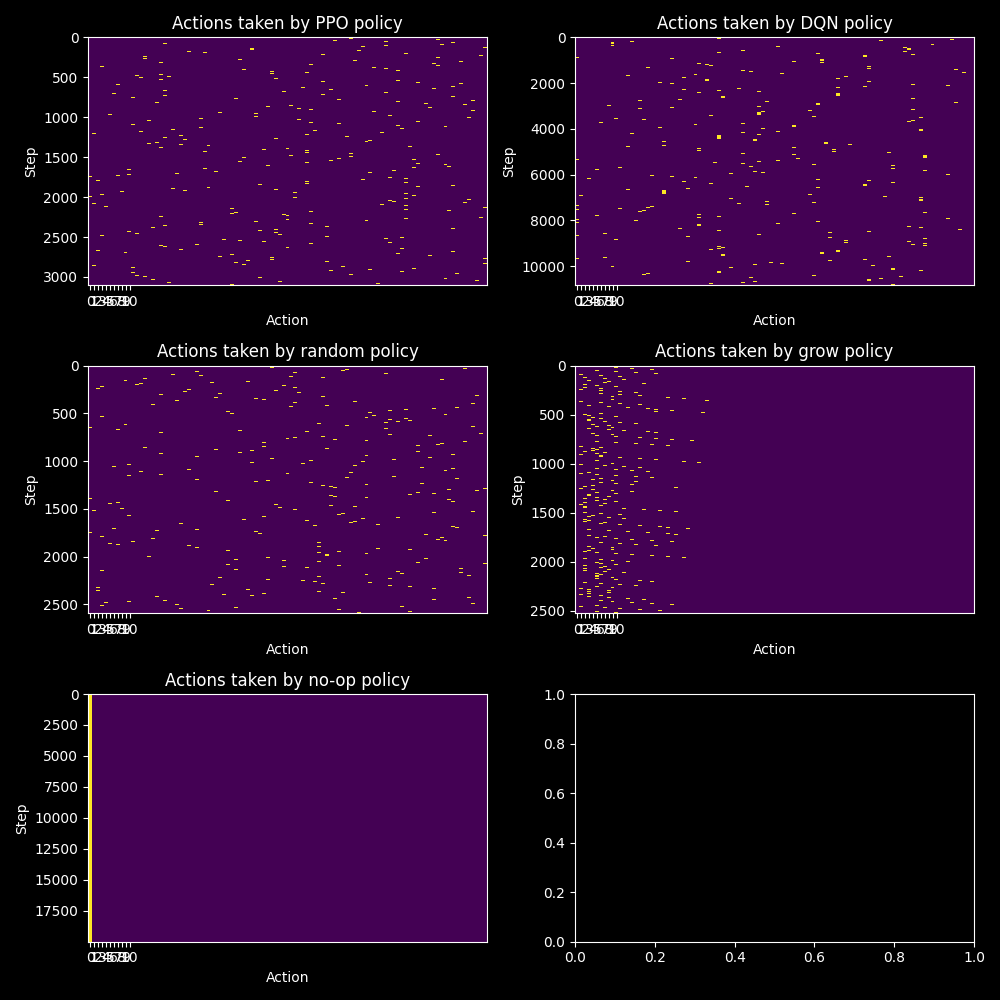

In [30]:
from keras.utils.np_utils import to_categorical

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))
for i, (policy_name, episodes) in enumerate(history.items()):
    ax = axes[i//2, i%2]
    ax.set_title(f"Actions taken by {policy_name} policy")
    actions = to_categorical(np.concatenate([e["actions"] for e in episodes]), num_classes=env.action_space.n)
    ax.imshow(actions, interpolation="nearest", aspect="auto")
    ax.set_xlabel("Action")
    ax.set_ylabel("Step")
    if num_episodes <= 25:
        for y in np.cumsum([e["length"] for e in episodes]):
            ax.axhline(y, color="white", alpha=0.2, linewidth=0.5)
    ax.set_xticks(np.arange(0,11,1))
    # ax.grid(alpha=0.1)
plt.tight_layout()
plt.savefig(figure_save_dir / f"actions.png", format="png", dpi=300, bbox_inches="tight")

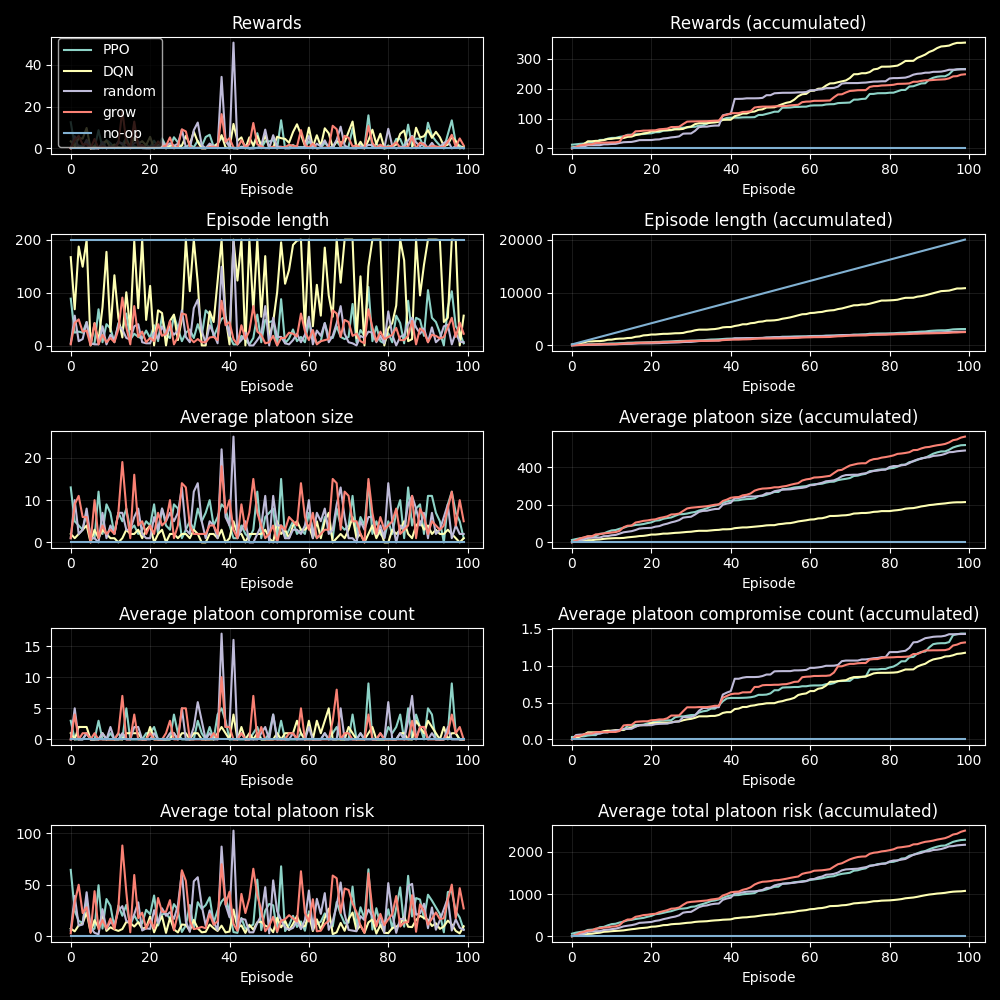

In [31]:
from statistics import mean


metrics = {
    "rewards": lambda episodes: [sum(e["rewards"]) for e in episodes],
    "rewards (accumulated)": lambda episodes: np.cumsum([sum(e["rewards"]) for e in episodes]),
    "episode length": lambda episodes: [e["length"] for e in episodes],
    "episode length (accumulated)": lambda episodes: np.cumsum([e["length"] for e in episodes]),
    "average platoon size": lambda episodes: [mean((info["members"]==1).sum() for info in e["infos"]) for e in episodes],
    "average platoon size (accumulated)": lambda episodes: np.cumsum([mean((info["members"]==1).sum() for info in e["infos"]) for e in episodes]),
    "average platoon compromise count": lambda episodes: [
        mean(
            ((info["probs"] == 1)*(info["members"]==1)[:,None]).sum()
            for info in e["infos"]
        )
        for e in episodes
    ],
    "average platoon compromise count (accumulated)": lambda episodes: np.cumsum([
        mean(
            ((info["probs"] == 1)*(info["members"]==1)[:,None]).sum(axis=1).mean()
            for info in e["infos"]
        )
        for e in episodes
    ]),
    "average total platoon risk": lambda episodes: [
        mean(
            ((info["members"]==1)[:,None]*info["severities"]).sum()
            for info in e["infos"]
        )
        for e in episodes   
    ],
    "average total platoon risk (accumulated)": lambda episodes: np.cumsum([
        mean(
            ((info["members"]==1)[:,None]*info["severities"]).sum()
            for info in e["infos"]
        )
        for e in episodes   
    ]),
}

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,10))
for i, (metric, measure) in enumerate(metrics.items()):
    ax = axes[i//2, i%2]
    for j, (policy_name, episodes) in enumerate(history.items()):
        ax.plot(measure(episodes), label=policy_name, alpha=1)   
    ax.set_title(f"{metric.capitalize()}")
    ax.set_xlabel("Episode")
    # ax.set_xticks(np.arange(0,num_episodes,1))
    if i == 0:
        ax.legend()
    ax.grid(alpha=0.1)
plt.tight_layout()
plt.savefig(figure_save_dir / f"metrics.png", format="png", dpi=300, bbox_inches="tight")

In [32]:
keep = {k: v for k, v in metrics.items() if "accumulated" not in k}
print(r"\begin{tabular}{" + r"|p{2cm}"*(len(keep)+1) + "|}\n\\hline")
print("Policy", end=" & ")
for i,metric in enumerate(keep.keys()):
    print(metric.capitalize(), end=" & " if i+1 != len(keep) else "\\\\")
print("\n\\hline")
for policy, episodes in history.items():
    print(policy, end=" & ")
    for i,metric in enumerate(keep.values()):
        print(f"{np.mean(metric(episodes)):.3f}", end=" & " if i+1 != len(keep) else "\\\\")
    print()

\begin{tabular}{|p{2cm}|p{2cm}|p{2cm}|p{2cm}|p{2cm}|p{2cm}|}
\hline
Policy & Rewards & Episode length & Average platoon size & Average platoon compromise count & Average total platoon risk\\
\hline
PPO & 2.656 & 31.020 & 5.190 & 1.110 & 22.810\\
DQN & 3.538 & 108.230 & 2.150 & 0.780 & 10.741\\
random & 2.646 & 25.950 & 4.900 & 1.140 & 21.632\\
grow & 2.479 & 25.250 & 5.640 & 0.990 & 24.972\\
no-op & 0.000 & 200.000 & 0.000 & 0.000 & 0.000\\


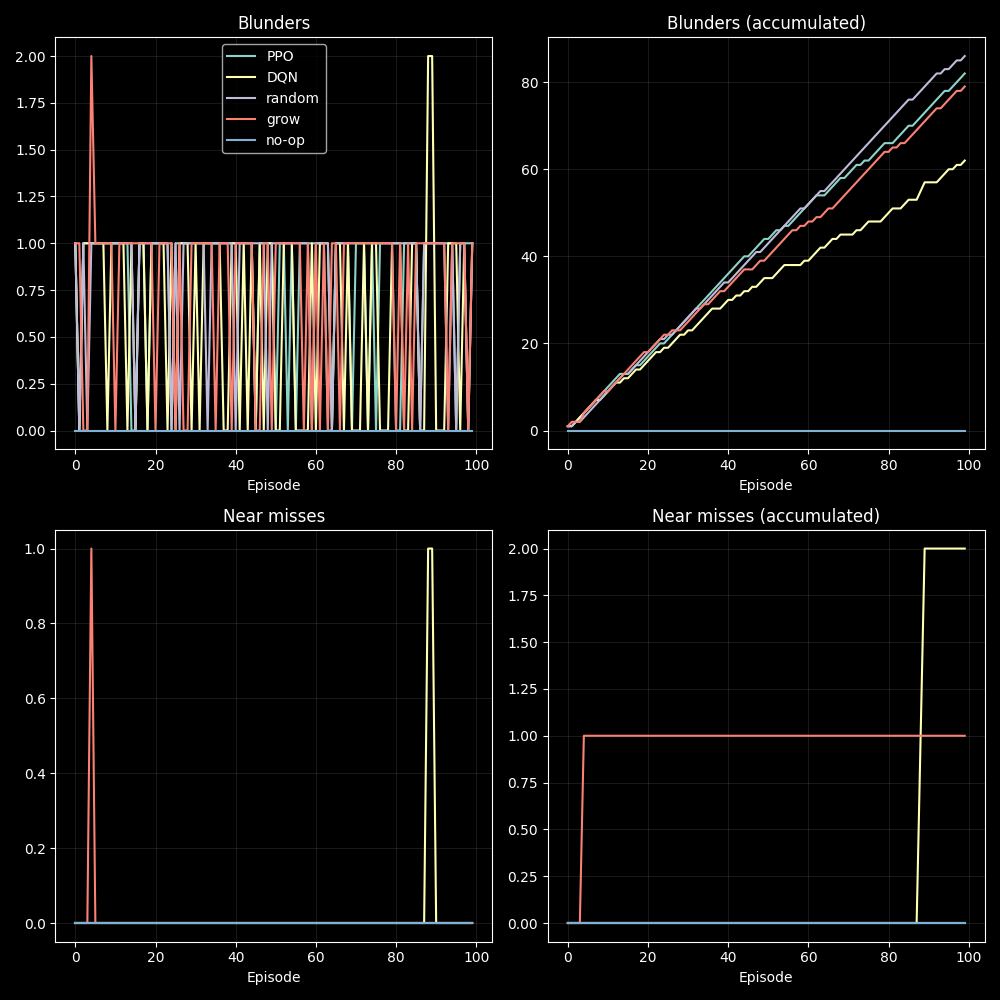

In [33]:
from statistics import mean


metrics = {
    "blunders": lambda episodes: [len(e["blunders"]) for e in episodes],
    "blunders (accumulated)": lambda episodes: np.cumsum([len(e["blunders"]) for e in episodes]),
    "near misses": lambda episodes: [len([x for x in e["blunders"] if not x["terminated"]]) for e in episodes],
    "near misses (accumulated)": lambda episodes: np.cumsum([len([x for x in e["blunders"] if not x["terminated"]]) for e in episodes]),
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for i, (metric, measure) in enumerate(metrics.items()):
    ax = axes[i//2, i%2]
    for j, (policy_name, episodes) in enumerate(history.items()):
        ax.plot(measure(episodes), label=policy_name, alpha=1)   
    ax.set_title(f"{metric.capitalize()}")
    ax.set_xlabel("Episode")
    # ax.set_xticks(np.arange(0,num_episodes,1))
    if i == 0:
        ax.legend()
    ax.grid(alpha=0.1)
plt.tight_layout()
plt.savefig(figure_save_dir / f"blunders.png", format="png", dpi=300, bbox_inches="tight")